# Домашнее задание 1. Извлечение ключевых слов

При выполнении домашнего задания можно пользоваться тетрадкой с семинара.

### Описание задания:

1. Подготовить мини-корпус (4-5 текстов или до 10 тысяч токенов) с разметкой ключевых слов.
Желательно указать источник корпуса и описать, в каком виде там были представлены ключевые слова.

2. Разметить ключевые слова самостоятельно. Оценить пересечение с имеющейся разметкой.

3. Применить к этому корпусу 3 метода извлечения ключевых слов на выбор (RAKE, TextRank, tf*idf, OKAPI BM25).

4. Оценить точность, полноту, F-меру выбранных методов относительно имеющейся разметки.

5. Описать ошибки автоматического выделения ключевых слов (что выделяется лишнее, что не выделяется);
предложить свои методы решения этих проблем.

### Критерии оценки:

По 2 балла на каждый пункт.

### Формат сдачи задания:

Jupyter-notebook на гитхабе (запишите адрес своего репозитория [сюда](https://forms.gle/Z4z3JsHbvM6Ghroo9))

### Дедлайн: 

18 ноября 2019 10:00мск

## Скачиваем нужные библиотеки

In [1]:
import re
import pandas as pd
from statistics import mean 
from textdistance import levenshtein
from nltk.tokenize import RegexpTokenizer
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('russian')
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

## Открываем тексты и ключевые слова


In [2]:
file_names = ['business', 'science', 'crime', 'politics']
keyword_file = 'keywords.txt'
texts_dict = {}
for f in file_names:
    fname = f+'.txt'
    with open(fname, 'r', encoding='utf-8') as src:
        text = src.read()
        texts_dict[f] = text

#### Лемматизируем:

In [3]:
tokenizer = RegexpTokenizer(r'\w+')

In [4]:
def preproc(text, stopwords, maximal=False):
    stopwords = set(stopwords)
    text = re.sub(r'\n', r' ', text)
    if maximal:
        text = re.sub(r'["%0-9A-Za-z]', r'', text)
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    newtext = ''
    for w in text:
        if w not in stopwords: 
            lemma = morph.parse(w)[0].normal_form + ' '
            newtext += lemma
    return newtext

In [5]:
preproc_texts_dict = {}
for t in texts_dict.keys():
    lemmatized = preproc(texts_dict[t], stop, maximal=False)
    preproc_texts_dict[t] = lemmatized

### И ключевые слова

In [6]:
keywords_dict = {}
keywords_lemmas_dict = {}
with open(keyword_file, 'r', encoding='utf-8') as src:
    kws = src.read()
    kws = kws.split('\n')
    for line in kws:
        text, keywords = (a for a in line.split(': '))
        keywords = keywords.split(', ')
        keywords_dict[text] = keywords
        kw_lemmas = []
        for kw in keywords:
            #kw = kw.split(' ')
            #for k_w in kw:
            lemmas = preproc(kw, stopwords=stop)
            kw_lemmas.append(lemmas[:-1])
        keywords_lemmas_dict[text] = kw_lemmas

In [7]:
keywords_lemmas_dict

{'politics': ['боливия',
  'государственный переворот',
  'эво моралеса',
  'протест',
  'выбор',
  'политический убежище'],
 'crime': ['московский дело',
  'никита чирец',
  'массовый беспорядок',
  'выбор мосгордума',
  'суд'],
 'business': ['четырехдневный рабочий неделя',
  'япония',
  'microsoft',
  'продуктивность'],
 'science': ['кот',
  'собака',
  'эмоция',
  'поведение',
  'человек',
  'дистанция',
  'язык телодвижение']}

In [8]:
keywords_dict

{'politics': ['Боливия',
  'государственный переворот',
  'Эво Моралес',
  'протесты',
  'выборы',
  'политическое убежище'],
 'crime': ['московское дело',
  'Никита Чирцов',
  'массовые беспорядки',
  'выборы в Мосгордуму',
  'суд'],
 'business': ['четырехдневная рабочая неделя',
  'Япония',
  'Microsoft',
  'продуктивность'],
 'science': ['кот',
  'собака',
  'эмоция',
  'поведение',
  'человек',
  'дистанция',
  'язык телодвижений']}

## Поиск ключевых слов в тексте

Делаем "тупой" поиск по подстрокам. Считаем, сколько получилось вхождений ключевых слов в каждом тексте.

In [9]:
def kw_brute_search(keywords, corpus):
    for name in keywords.keys():
        print(name)
        text = corpus[name]
        kws = keywords[name]
        for kw in kws:
            kw_occs = text.count(kw)
            print(f'{kw} - {kw_occs}')
        print('-----------------')
    return 'done'

#### не-лемматизированные тексты

In [10]:
kw_brute_search(keywords_dict, texts_dict)

politics
Боливия - 2
государственный переворот - 1
Эво Моралес - 3
протесты - 1
выборы - 4
политическое убежище - 2
-----------------
crime
московское дело - 0
Никита Чирцов - 0
массовые беспорядки - 0
выборы в Мосгордуму - 0
суд - 21
-----------------
business
четырехдневная рабочая неделя - 0
Япония - 0
Microsoft - 5
продуктивность - 1
-----------------
science
кот - 31
собака - 6
эмоция - 0
поведение - 2
человек - 8
дистанция - 0
язык телодвижений - 0
-----------------


'done'

не очень...

#### лемматизированные тексты

In [11]:
kw_brute_search(keywords_lemmas_dict, preproc_texts_dict)

politics
боливия - 24
государственный переворот - 4
эво моралеса - 3
протест - 7
выбор - 13
политический убежище - 3
-----------------
crime
московский дело - 2
никита чирец - 0
массовый беспорядок - 1
выбор мосгордума - 0
суд - 23
-----------------
business
четырехдневный рабочий неделя - 1
япония - 1
microsoft - 5
продуктивность - 1
-----------------
science
кот - 32
собака - 21
эмоция - 1
поведение - 4
человек - 15
дистанция - 1
язык телодвижение - 4
-----------------


'done'

Очень неплохо! Особенно когда идет поиск по изолированным ключевым словам.


## Rake

In [12]:
import RAKE

In [13]:
rake = RAKE.Rake(stop)

### Нелемматизированные тексты

In [14]:
kw_pred_dict = {}
for text in texts_dict.keys():
    print(text+':')
    rake_kw_list = rake.run(texts_dict[text], maxWords=3, minFrequency=2)
    kw_list = []
    for kw in rake_kw_list[:15]:
        print(kw)
        kw_list.append(kw[0])
    kw_pred_dict[text] = kw_list
    print('-----------')

business:
('месяц', 1.6666666666666667)
('говорится', 1.0)
('проведенного', 1.0)
-----------
science:
('большей части общаются', 9.0)
('языке телодвижений', 4.5)
('подчеркивает витале', 4.5)
('говорит хистэнд', 4.25)
('своим предкам', 4.0)
('говорит', 2.0)
('это', 1.8888888888888888)
('кошки', 1.6875)
('просто', 1.5)
('хозяина', 1.3333333333333333)
('собаки', 1.3)
('собаками', 1.0)
('понимаем', 1.0)
('чувствуют', 1.0)
('судить', 1.0)
-----------
crime:
('область грудной клетки', 8.666666666666666)
('снимается вопрос', 3.75)
('суда', 2.0)
('сизо', 1.6666666666666667)
('из-', 1.3333333333333333)
('аквариума', 1.0)
('побежал', 1.0)
-----------
politics:
('би-би-си', 9.0)
('тех пор', 4.0)
('это', 2.0)
('боливии', 2.0)
('стране', 1.75)
('отставку', 1.6666666666666667)
('пока', 1.6666666666666667)
('заявил', 1.6666666666666667)
('моралес', 1.5714285714285714)
('однако', 1.3333333333333333)
('отставке', 1.0)
('уйти', 1.0)
('призвали', 1.0)
('беседе', 1.0)
('бразилии', 1.0)
-----------


## Метрика оценки:
* учитывая, что у русского языка развитая морфология, искать соответствие просто по словам неправильно. Моя идея - сравнивать каждое найденное ключевое слово по нормированному расстоянию Левенштейна с реальными ключевыми словами. 
* учитывая, что в нашей задаче отсутствует как таковая категория True Negative, которая необходима для традиционного вычисления метрик precision, accuracy и recall, мы будем высчитывать метрики так:
    * Accuracy = True Positive / (True Positive + False Negative + False Positive + 1)
    * Precision = True Positive / (True Positive + False Positive + 1)
    * Recall = True Positive / (True Positive + False Negative + 1)
, где 1 запрещает деление на ноль.

In [15]:
def evaluation(y, pred, threshold=0.7):
    
    tp, fp, fn = 0, 0, 0
    
    kw_y_used = set()
    for kw_pred in pred:
        likelihood_list = sorted([(levenshtein.normalized_similarity(kw_pred, y[i]), y[i]) for i in range(len(y))])
        likeliest_score, likeliest = likelihood_list[-1]

        if likeliest_score > threshold:
            tp += 1
            kw_y_used.add(likeliest)
        else:
            fp += 1
    for y_kw in y:
        if y_kw not in kw_y_used:
            fn += 1
    
    accuracy = tp / (tp + fn + fp + 1)
    precision = tp / (tp + fp + 1)
    recall = tp / (tp + fn + 1)
    f1 = (2 * precision * recall) / (precision + recall + 1)

    return precision, accuracy, f1 

In [16]:
def mean_metrics(y, pred, threshold=0.7):
    aver_prec, aver_acc, aver_f1 = [], [], []
    for text_name in y.keys():
        precision, accuracy, f1 = evaluation(y[text_name], pred[text_name], threshold=threshold)
        aver_prec.append(precision)
        aver_acc.append(accuracy)
        aver_f1.append(f1)
    aver_prec = mean(aver_prec)
    aver_acc = mean(aver_acc)
    aver_f1 = mean(aver_f1)
    return aver_prec, aver_acc, aver_f1

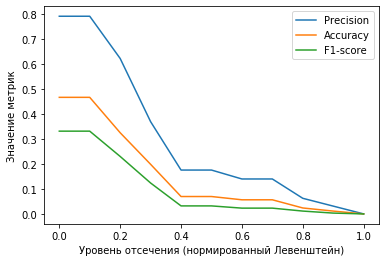

In [18]:
import matplotlib.pyplot as plt

thresholds = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
precs = []
accs = []
f1s = []

for el in thresholds:
    prec, acc, f1 = mean_metrics(kw_pred_dict, keywords_dict, threshold=el)
    precs.append(prec)
    accs.append(acc)
    f1s.append(f1)

plt.plot(thresholds, precs)
plt.plot(thresholds, accs)
plt.plot(thresholds, f1s)
plt.legend(['Precision', 'Accuracy', 'F1-score'])
plt.xlabel('Уровень отсечения (нормированный Левенштейн)')
plt.ylabel('Значение метрик')
plt.show()

### Лемматизированные тексты

для этого вначале запрепроцессим тексты без стоп-слов. Иначе RAKE не будет работать.

In [19]:
def preproc_rake(text, maximal=False):
    text = re.sub(r'\n', r' ', text)
    if maximal:
        text = re.sub(r'["%0-9A-Za-z]', r'', text)
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    newtext = ''
    for w in text:
        lemma = morph.parse(w)[0].normal_form + ' '
        newtext += lemma
    return newtext

In [20]:
rake_preproc_texts_dict = {}
for t in texts_dict.keys():
    lemmatized = preproc_rake(texts_dict[t], maximal=False)
    rake_preproc_texts_dict[t] = lemmatized

In [21]:
kw_pred_dict = {}

for text in texts_dict.keys():
    print(text+':')
    rake_kw_list = rake.run(preproc_texts_dict[text], maxWords=3, minFrequency=1)
    kw_list = []
    for kw in rake_kw_list[:15]:
        print(kw)
        kw_list.append(kw[0])
    kw_pred_dict[text] = kw_list
    print('______________')

business:
______________
science:
('смысл совместный эволюция', 9.0)
('явно нравиться компания', 9.0)
('это обязательно вино', 9.0)
('оставить покой', 4.0)
('грамм правда', 4.0)
('вести собака', 4.0)
('навязчивый внимание', 4.0)
('2007 год поехать', 4.0)
('показывать рад', 4.0)
('свой манер', 4.0)
('порядок', 1.0)
______________
crime:
('встретить сергей абаничев', 9.0)
('вопрос примирение рассматривать', 9.0)
('сотрудник полиция предложение', 9.0)
('обсуждать процедура', 4.0)
('часы', 1.0)
______________
politics:
('посольство остаться родина', 9.0)
('россия сотрудничать моралесом', 9.0)
('сменить моралеса', 4.0)
('пора пока', 4.0)
('реакция', 1.0)
('надеяться', 1.0)
______________


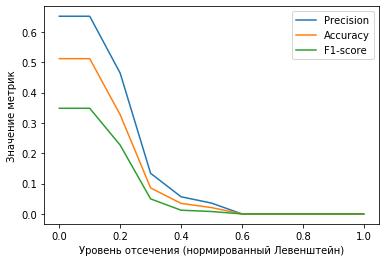

In [22]:
thresholds = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
precs = []
accs = []
f1s = []

for el in thresholds:
    prec, acc, f1 = mean_metrics(keywords_lemmas_dict, kw_pred_dict, threshold=el)
    precs.append(prec)
    accs.append(acc)
    f1s.append(f1)

plt.plot(thresholds, precs)
plt.plot(thresholds, accs)
plt.plot(thresholds, f1s)
plt.legend(['Precision', 'Accuracy', 'F1-score'])
plt.xlabel('Уровень отсечения (нормированный Левенштейн)')
plt.ylabel('Значение метрик')
plt.show()

## TextRank

In [23]:
from gensim.summarization import keywords as kw

#### Нелемматизированные тексты

In [24]:
from gensim.summarization import keywords as kw

kw_pred_dict = {}

for text in texts_dict.keys():
    print(text+':')
    text_rank = kw(texts_dict[text], pos_filter=[], scores=True)
    kw_list = []
    for k_w in text_rank[:15]:
        print(f'{k_w[0]}\t{k_w[1]}')
        kw_list.append(k_w[0])
    print('_________________\n\n')
    kw_pred_dict[text] = kw_list

business:
что	0.24671478520666948
microsoft	0.18203806208017062
это	0.18095830990163594
компании	0.16851884133616327
сотрудники	0.14718268167618745
как	0.11745256717674206
сотрудникам	0.10808285749458095
существует	0.1002607957146042
года	0.09567784394788778
страны работают	0.08750775137850719
четырехдневнои	0.08537155766586106
наоборот	0.08515591391750094
министерству	0.08515591391750034
количество	0.08515591391750002
кроме	0.08515591391749996
_________________


science:
это	0.22352529579556685
или	0.20290370212087466
кошки живут	0.15985075564271964
кажется что	0.159651770438366
когда они	0.15859588327865748
собаки	0.12299706095732335
вас	0.11730665189698175
есть	0.10039179152418759
она	0.09950847283981581
как животное его	0.09753802514710969
только	0.09460823883672724
так	0.09400131568325777
говорит	0.09034008320299597
телодвижении кошек	0.08880966582184606
животных	0.08835034983846037
_________________


crime:
что	0.24033425994955157
чирцова	0.23406989086977278
как	0.2016671760492

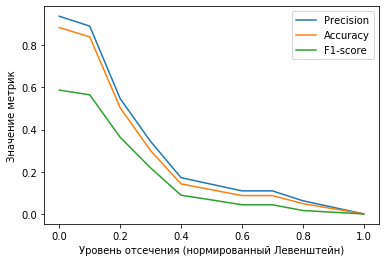

In [25]:
thresholds = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
precs = []
accs = []
f1s = []

for el in thresholds:
    prec, acc, f1 = mean_metrics(keywords_dict, kw_pred_dict, threshold=el)
    precs.append(prec)
    accs.append(acc)
    f1s.append(f1)

plt.plot(thresholds, precs)
plt.plot(thresholds, accs)
plt.plot(thresholds, f1s)
plt.legend(['Precision', 'Accuracy', 'F1-score'])
plt.xlabel('Уровень отсечения (нормированный Левенштейн)')
plt.ylabel('Значение метрик')
plt.show()

#### Лемматизированные тексты

In [26]:
kw_pred_dict = {}

for text in texts_dict.keys():
    print(text+':')
    text_rank = kw(preproc_texts_dict[text], pos_filter=[], scores=True)
    kw_list = []
    for k_w in text_rank[:15]:
        print(f'{k_w[0]}\t{k_w[1]}')
        kw_list.append(k_w[0])
    kw_pred_dict[text] = kw_list
    print('_________________\n\n')

business:
японскии	0.16777632661582717
это	0.16552304378760005
microsoft	0.16193307017117925
рабочии день	0.15634711162808895
сотрудник месяц работать пятница как	0.15094876115054442
компания	0.14817323698433046
год существовать	0.1390905906434235
дополнительныи	0.11914303424608595
выходнои	0.11639505900456201
результат	0.11582986390210391
неделя	0.1013596149476318
время сказать	0.10083619594301817
ход	0.09551008135069966
которыи	0.09540672182327117
введение	0.09523252312018783
_________________


science:
кошка гораздо	0.3078761992009197
собака	0.25204747576036024
это	0.21135629835208702
которыи	0.1839517278558074
свои	0.16662082658857974
жить человек	0.14877784892754697
хозяин	0.12632995459065632
кошачии	0.07890713849992231
кот общение	0.07713221607089198
считаться один	0.0769178387289707
место	0.06717539969591821
животное частично	0.0660550327465352
очень	0.06531520407720894
имидж	0.06468919699153863
дать исследование	0.06425529736440069
_________________


crime:
чирцовыи	0.2306194

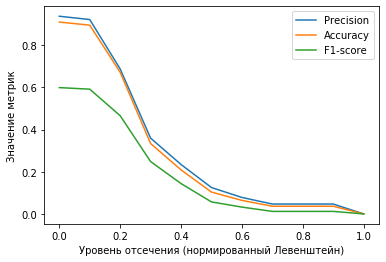

In [27]:
thresholds = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
precs = []
accs = []
f1s = []

for el in thresholds:
    prec, acc, f1 = mean_metrics(keywords_lemmas_dict, kw_pred_dict, threshold=el)
    precs.append(prec)
    accs.append(acc)
    f1s.append(f1)

plt.plot(thresholds, precs)
plt.plot(thresholds, accs)
plt.plot(thresholds, f1s)
plt.legend(['Precision', 'Accuracy', 'F1-score'])
plt.xlabel('Уровень отсечения (нормированный Левенштейн)')
plt.ylabel('Значение метрик')
plt.show()

## Tf-Idf


#### Нелемматизированные тексты

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [29]:
corpus = list(texts_dict.values())

In [30]:
cv=CountVectorizer(max_features=10000) #stop_words=stopwords,
word_count_vector=cv.fit_transform(corpus)

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tf_idf_vector=tfidf_transformer.fit_transform(word_count_vector)

df = pd.DataFrame(tf_idf_vector.toarray(), columns=cv.get_feature_names(), index=texts_dict.keys())

stop = set(stop)
words = set(df.columns)

stop_words = stop.intersection(words)
for w in stop_words:
    df = df.drop([w], axis=1)
df = df.T

In [31]:
col_names = list(df.columns)

kw_pred_dict = {}

for col in col_names:
    kws = df.nlargest(15, col)
    kws = kws[col]
    print(col)
    print(kws)
    kw_pred_dict[col] = list(kws.index)
    print('___________')


business
microsoft      0.233574
компании       0.186859
месяц          0.140144
недели         0.140144
рабочей        0.140144
сотрудникам    0.140144
сотрудники     0.110491
это            0.097511
2019           0.093430
выводу         0.093430
выходные       0.093430
говорится      0.093430
дней           0.093430
заявлении      0.093430
корпорации     0.093430
Name: business, dtype: float64
___________
science
кошки       0.320517
собаки      0.185562
кошек       0.168693
это         0.123243
животных    0.084346
кот         0.084346
кошка       0.084346
просто      0.084346
говорит     0.079800
нам         0.079800
витале      0.067477
гораздо     0.067477
коты        0.067477
очень       0.067477
понять      0.067477
Name: science, dtype: float64
___________
crime
чирцова      0.293059
суд          0.161736
адвокат      0.146529
суда         0.146529
27           0.117223
июля         0.117223
михаленок    0.117223
полиции      0.117223
судья        0.117223
чирцов       0.1172

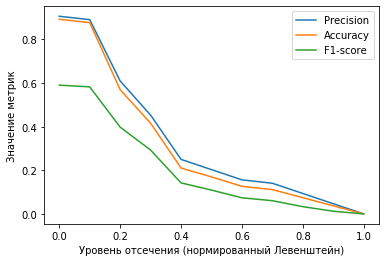

In [32]:
thresholds = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
precs = []
accs = []
f1s = []

for el in thresholds:
    prec, acc, f1 = mean_metrics(keywords_lemmas_dict, kw_pred_dict, threshold=el)
    precs.append(prec)
    accs.append(acc)
    f1s.append(f1)

plt.plot(thresholds, precs)
plt.plot(thresholds, accs)
plt.plot(thresholds, f1s)
plt.legend(['Precision', 'Accuracy', 'F1-score'])
plt.xlabel('Уровень отсечения (нормированный Левенштейн)')
plt.ylabel('Значение метрик')
plt.show()

#### Лемматизированные тексты

In [33]:
corpus = list(preproc_texts_dict.values())

cv=CountVectorizer(max_features=10000) #stop_words=stopwords,
word_count_vector=cv.fit_transform(corpus)

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tf_idf_vector=tfidf_transformer.fit_transform(word_count_vector)

df = pd.DataFrame(tf_idf_vector.toarray(), columns=cv.get_feature_names(), index=texts_dict.keys())

stop = set(stop)
words = set(df.columns)

stop_words = stop.intersection(words)
for w in stop_words:
    df = df.drop([w], axis=1)

df = df.T

In [34]:
col_names = list(df.columns)

kw_pred_dict = {}

for col in col_names:
    kws = df.nlargest(15, col)
    kws = kws[col]
    print(col)
    print(kws)
    kw_pred_dict[col] = list(kws.index)
    print('___________')


business
рабочий           0.364951
сотрудник         0.323698
microsoft         0.228094
японский          0.228094
компания          0.179832
неделя            0.143866
работать          0.143866
выходной          0.136856
дополнительный    0.136856
год               0.119029
день              0.107899
месяц             0.107899
результат         0.107899
это               0.095223
2019              0.091238
Name: business, dtype: float64
___________
science
кошка       0.653909
собака      0.334929
хозяин      0.143541
кот         0.127592
который     0.124843
человек     0.124843
это         0.116520
животное    0.111643
свой        0.099874
жить        0.095694
предок      0.095694
кошачий     0.079745
просто      0.079745
витала      0.063796
гораздо     0.063796
Name: science, dtype: float64
___________
crime
суд            0.318807
чирцовый       0.311051
адвокат        0.186630
боль           0.186630
задержать      0.155525
судья          0.155525
полицейский    0.147142
27  

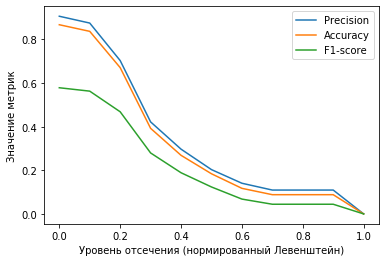

In [35]:
thresholds = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
precs = []
accs = []
f1s = []

for el in thresholds:
    prec, acc, f1 = mean_metrics(keywords_lemmas_dict, kw_pred_dict, threshold=el)
    precs.append(prec)
    accs.append(acc)
    f1s.append(f1)

plt.plot(thresholds, precs)
plt.plot(thresholds, accs)
plt.plot(thresholds, f1s)
plt.legend(['Precision', 'Accuracy', 'F1-score'])
plt.xlabel('Уровень отсечения (нормированный Левенштейн)')
plt.ylabel('Значение метрик')
plt.show()

## Выводы

* качество нахождения ключевых слов (и количество кандидатов) напрямую зависит от размера текста; поэтому лучше всего находились ключевые слова в рубрике politics и business (каждый из текстов - более 2 тыс. слов), хуже всего - в science и crime (до тысячи слов каждый из текстов).
* для RAKE заметна тенденция к тому, чтобы находить более длинные последовательности ключевых слов при удлинении текста; печально, что именно на нашей выборке самые длинные последовательности ключевых слов встречались как раз в самых коротких текстах.
* лемматизация не очень сильно влияет на качество выдачи. Она немного повышает его в алгоритме RAKE, в остальных методах мало изменяет результаты
* лучшее качество по результатам выдачи - у TextRank и Tf-Idf; самое плохое - у RAKE.
* метрики не вызывают большого доверия - показывая большие цифры, они по сути не "срезают" лишние варианты; после значения 0.4 обычно идет резкий спад, показывающий точность меньше 50%. Тем не менее, если посмотреть результаты выдачи, можно убедиться, что не все так плохо.
* вопрос метрики - как-то лучше придумывать словоделение
* возможно надо применить лемматизацию и пословно проверять, делать дробную метрику как тут: https://lct-master.org/getfile.php?id=2676&n=1&dt=TH&ft=pdf&type=TH (стр. 37).